# Step 5: Model Construction, Evaluation, and Analysis

**Metis Project 2, Andrew Zhou**

With our data scraped and cleaned, we move on to the building the actual model.

In [145]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from scipy.stats import kruskal

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

In [146]:
data_df = pd.read_pickle("../data/anime_sales_df_final.pickle")

In [147]:
print(data_df.columns.tolist(), "\n", len(data_df))

['title', 'year', 'season_qtr', 'studio', 'source', 'link', 'episodes', 'broadcast', 'genres', 'duration', 'rating', 'score', 'members', 'favorites', 'day', 'time', 'hour', 'runtime', 'Game', 'Sci-Fi', 'Adventure', 'Mystery', 'Magic', 'Fantasy', 'Comedy', 'Shounen', 'Drama', 'Action', 'Mecha', 'Seinen', 'Demons', 'Josei', 'Military', 'Ecchi', 'Super Power', 'Supernatural', 'Music', 'Romance', 'School', 'Slice of Life', 'Parody', 'Shoujo', 'Historical', 'Harem', 'Police', 'Sports', 'Martial Arts', 'Psychological', 'Shoujo Ai', 'Space', 'Samurai', 'Horror', 'Thriller', 'Vampire', 'Shounen Ai', 'sales'] 
 1307


Our variables and the length of the DF; we've got ~1300 data points.

In [148]:
data_df.head(3)

,title,year,season_qtr,studio,source,link,episodes,broadcast,genres,duration,...,Martial Arts,Psychological,Shoujo Ai,Space,Samurai,Horror,Thriller,Vampire,Shounen Ai,sales
.hack//SIGN,.hack//SIGN,2002,Spring,Bee Train,game,https://myanimelist.net/anime/48/hack__Sign,26,"(None, None)","[Game, Sci-Fi, Adventure, Mystery, Magic, Fant...",24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,362.2
.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu,2003,Winter,Bee Train,game,https://myanimelist.net/anime/298/hack__Tasoga...,12,"(None, None)","[Adventure, Comedy, Fantasy, Game, Sci-Fi, Sho...",23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.8
.hack//Roots,.hack//Roots,2006,Spring,Bee Train,game,https://myanimelist.net/anime/873/hack__Roots,26,"(None, None)","[Adventure, Drama, Fantasy, Game, Sci-Fi]",24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0


## Initial EDA

Let's take a look at our data, particularly our response variable and our predictor variables' correlations with said response.

In [149]:
data_df["sales"].describe()

count    1307.000000
mean      105.311706
std       110.065206
min         0.400000
25%        24.000000
50%        64.600000
75%       152.600000
max       491.300000
Name: sales, dtype: float64

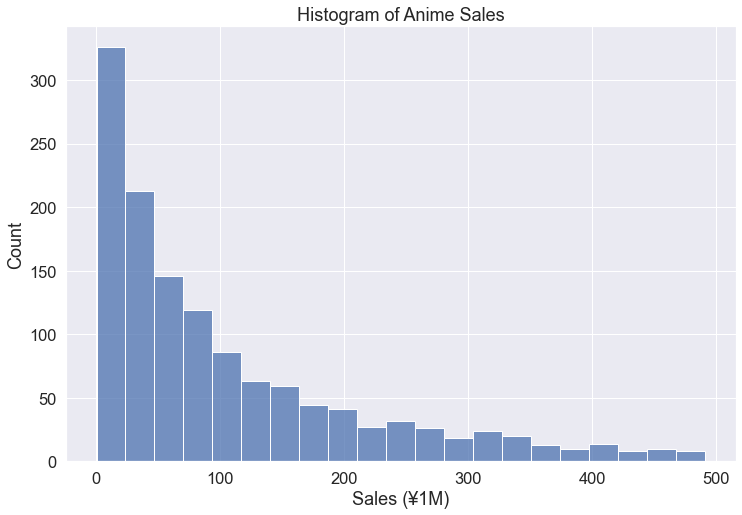

In [150]:
g = sns.histplot(data=data_df, x="sales")
g.set_title("Histogram of Anime Sales")
g.set_xlabel("Sales (¥1M)");

We've got a right-skewed distribution with a long tail. Most anime don't sell very many DVDs.

### Examining feature and predictor correlations

Let's look at the correlations of various continuous features with sales.

In [151]:
data_df.corr()["sales"].sort_values(key=lambda x: abs(x), ascending=False).head(10)

sales        1.000000
score        0.293095
favorites    0.235178
members      0.218380
year        -0.200427
runtime      0.103338
Harem        0.103076
hour        -0.100737
episodes     0.100055
Comedy       0.085402
Name: sales, dtype: float64

In [154]:
genre_list = np.unique(data_df["genres"].aggregate(sum))
# Manually delete two genres whose columns we already removed
genre_list = np.delete(genre_list, np.where((genre_list == "Cars")|(genre_list == "Dementia")))
data_df.drop(labels=genre_list, axis=1).corr()

,year,episodes,duration,score,members,favorites,hour,runtime,sales
year,1.000000,-0.294162,-0.107784,-0.006609,0.216078,0.048903,0.207049,-0.303853,-0.200427
episodes,-0.294162,1.000000,-0.011660,0.211623,-0.039650,0.108555,-0.009463,0.989342,0.100055
duration,-0.107784,-0.011660,1.000000,-0.014573,0.038680,0.027467,-0.039767,0.119510,0.031419
score,-0.006609,0.211623,-0.014573,1.000000,0.424309,0.506854,-0.129513,0.207915,0.293095
members,0.216078,-0.039650,0.038680,0.424309,1.000000,0.772227,-0.044680,-0.033508,0.218380
favorites,0.048903,0.108555,0.027467,0.506854,0.772227,1.000000,-0.095758,0.110439,0.235178
hour,0.207049,-0.009463,-0.039767,-0.129513,-0.044680,-0.095758,1.000000,-0.015870,-0.100737
runtime,-0.303853,0.989342,0.119510,0.207915,-0.033508,0.110439,-0.015870,1.000000,0.103338
sales,-0.200427,0.100055,0.031419,0.293095,0.218380,0.235178,-0.100737,0.103338,1.000000


Omitting our various genres, it like our strongest potential associations are with score, year, members, and favorites. As might be expected, members and favorites are highly collinear, so let's omit favorites. Let's look at the pair plots for score, year, members, and sales.

In [155]:
genre_list

array(['Action', 'Adventure', 'Comedy', 'Demons', 'Drama', 'Ecchi',
       'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire'], dtype='<U13')

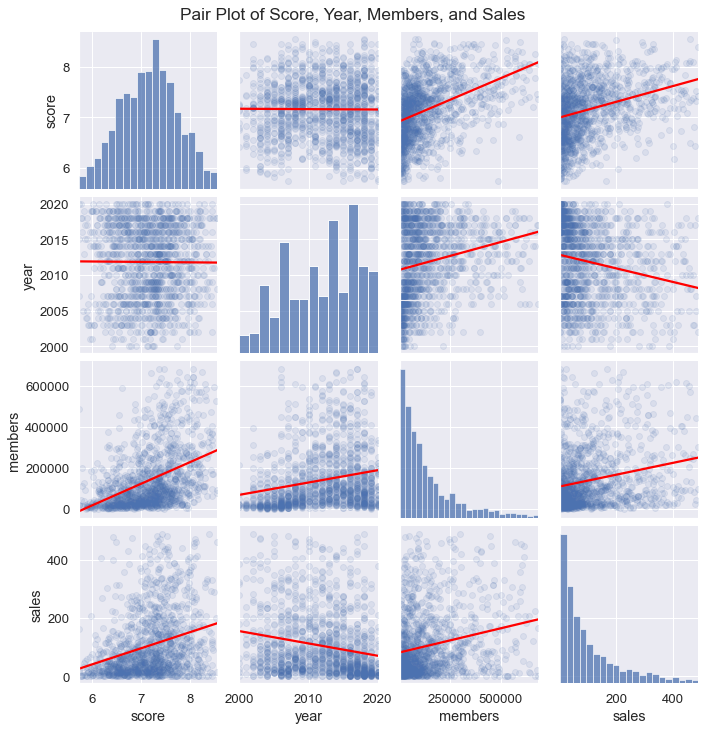

In [157]:
sns.set(font_scale=1.2)
g = sns.pairplot(data_df[["score", "year", "members", "sales"]], kind="reg",\
             plot_kws={'ci': False, 'line_kws':{'color':'red'},\
                       'scatter_kws': {'alpha': 0.1}})
plt.suptitle("Pair Plot of Score, Year, Members, and Sales", y=1.015);

We see evidence of some linear relationships between the features and sales, but there's a lot of noise, hence the <0.3 correlations.

In [158]:
# Reset font size
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

### Our train-test split

Let's do a train test split for our final model evaluation. All of our training will be on just the training set.

In [159]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data_df.drop(["sales"], axis=1), data_df["sales"], test_size=.2, random_state=1000)

### Base model: simple linear regression on score, year, and members

We'll do simple linear regression with score, year, and members as features. This will be our baseline, and we'll 
attempt to improve on it with more complex models.

Cross-validation score: 0.12174340784902624


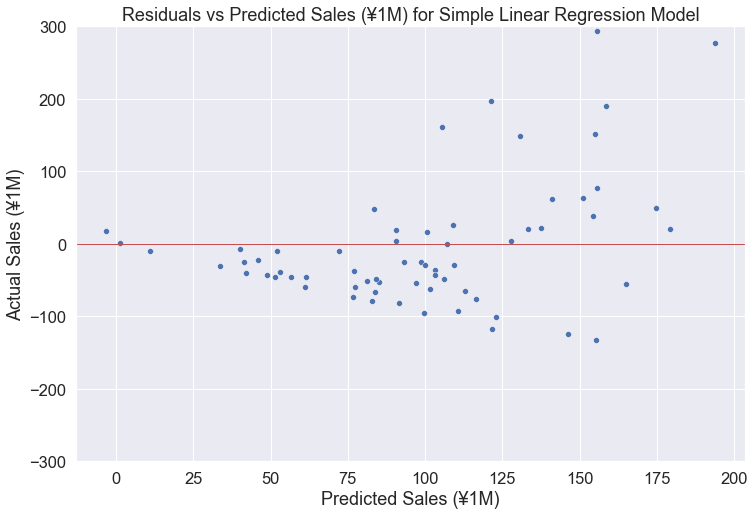

In [160]:
features = ["score", "members", "year"]
X_trainval_dum = pd.get_dummies(X_trainval[features])

train_scores = []
val_scores = []

kf = KFold(n_splits=15, shuffle=True, random_state=1000)

for train_idx, val_idx in kf.split(X_trainval_dum):
    lm = LinearRegression()
    X_train, X_val = X_trainval_dum.iloc[train_idx], X_trainval_dum.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    lm.fit(X_train, y_train)
    y_val_predict = lm.predict(X_val)
    train_scores.append(lm.score(X_train, y_train))
    val_scores.append(lm.score(X_val, y_val))

print("Cross-validation score:", np.mean(val_scores))
    
# residual plot for the last train/val split
g = sns.scatterplot(x=y_val_predict, y=y_val-y_val_predict)
plt.axhline(linewidth=1, color='r');
g.set_title("Residuals vs Predicted Sales (¥1M) for Simple Linear Regression Model")
g.set_xlabel("Predicted Sales (¥1M)")
g.set_ylabel("Actual Sales (¥1M)");
g.set_ylim((-300,300));

We see that the residuals seem to have larger positive magnitudes than negative ones; it seems we overpredict by large amounts sometimes, as might be expected given that the sales distribution skews right. The results also seem to have more variance for larger predicted values. It's worth keeping an eye on to see whether our improved model deals with these issues.

## Ridge and Lasso Regression

### Function Definition

Now let's move to more advanced techniques. We define ridge and lasso functions.

In [161]:
def ridge_regress(features, scale=True, seed=1000):    
    """
    Perform ridge regression with 15-fold cross-validation on our dataset
    with the specified features.
    
    :param list of str features: a list of the column names of the features
        to regress on
    :param bool scale: whether to standardize the values before regressing; 
        default True
    :param int seed: a random seed for KFold
    
    :return RidgeCV lm: the fitted RidgeCV object 
    :return float cv_score: the best cross-validation R2 score
    :return StandardScaler scaler: the fitted StandardScaler
    """
    X_trainval_dum = pd.get_dummies(X_trainval[features])

    X_train = X_trainval_dum
    y_train = y_trainval
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

    kf = KFold(n_splits=15, shuffle=True, random_state=seed)

    lm = RidgeCV(cv=kf, alphas=np.arange(0.1, 100, 1))
    lm.fit(X_train, y_train)

    train_score = lm.score(X_train, y_train)
    cv_score = lm.best_score_
    
    return lm, cv_score, scaler

In [162]:
def lasso_regress(features, scale=True, polynomial=False, int_only=False, degree=2, seed=1000):    
    """
    Perform ridge regression with 15-fold cross-validation on our dataset
    with the specified features.
    
    :param list of str features: a list of the column names of the features
        to regress on
    :param bool scale: whether to standardize the values before regressing; 
        default True
    :param bool polynomial: whether to use polynomial features, default False
    :param bool int_only: if polynomial is True, whether to use only 
        interaction polynomial features, default False
    :param int degree: if polynomial is True, the degree for polynomial 
        features, default 2
    :param int seed: a random seed for KFold
    
    :return LassoCV lm: the fitted RidgeCV object 
    :return float cv_score: the best cross-validation R2 score (estimated
        by comparing the best MSE to the variance of the training set)
    :return StandardScaler scaler: the fitted StandardScaler (currently does
        not return the PolynomialFeatures object, so do not use if polynomial
        is True)
    """
    X_trainval_dum = pd.get_dummies(X_trainval[features])

    X_train = X_trainval_dum
    y_train = y_trainval
    
    if polynomial:
        poly = PolynomialFeatures(degree, interaction_only=int_only)
        X_train = poly.fit_transform(X_train)
        print("Poly input features:", poly.n_input_features_)
        print("Poly output features:", poly.n_output_features_)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    

    kf = KFold(n_splits=15, shuffle=True, random_state=seed)

    lm = LassoCV(cv=kf, max_iter = 30000)
    lm.fit(X_train, y_train)

    train_score = lm.score(X_train, y_train)
    
    # Calculate the cross-validation score as r2, so as to be comparable to other
    # r2 measures produced in this project. 
    cv_score = 1-np.mean(lm.mse_path_, axis=1).min()/np.var(y_train)
    
    return lm, cv_score, scaler

### Ridge and Lasso Preliminary Tests

Let's try Ridge and Lasso regression on the dataset now and compare our results to OLS regression.

In [163]:
features = ["score", "year", "members"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print("Ridge CV R2:", cv_score_r)
print("Lasso CV R2:", cv_score_l)

Ridge CV R2: 0.12269807403659513
Lasso CV R2: 0.13555828866721054


Our ridge and lasso scores are very slightly better than our OLS validation score, suggesting that overfitting is not a huge issue with only these 3 regressors. Let's start adding in more features. Our remaining ones are mostly categorical so let's look at those.

In [164]:
data_df["rating"].value_counts()

PG-13    909
R        226
R+       140
G         20
PG        12
Name: rating, dtype: int64

In [165]:
features = ["score", "year", "members", "rating"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.13122483055048498 0.14522285819122016


Adding in rating improves our score somewhat.

In [166]:
data_df["source"].value_counts()

manga           593
original        262
novel           254
visual novel    105
game             72
Name: source, dtype: int64

In [167]:
features = ["score", "year", "members", "rating", "source"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.1513337413922464 0.16363195805504083


As does adding in the source of the anime material.

In [168]:
data_df["day"].value_counts()

Friday       162
Sunday       147
Saturday     132
Tuesday      114
Thursday     104
Monday        87
Wednesday     71
Name: day, dtype: int64

In [169]:
features = ["score", "year", "members", "rating", "source", "day"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.14700940522363068 0.1596888463639523


In [170]:
data_df["season_qtr"].value_counts()

Spring    369
Fall      356
Summer    303
Winter    279
Name: season_qtr, dtype: int64

In [171]:
features = ["score", "year", "members", "rating", "source", "season_qtr"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.14650980736771962 0.1604775687300305


In [172]:
features = ["score", "year", "members", "rating", "source", "day", "season_qtr"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.14182103426983295 0.1573636532625231


Adding in day and season actually decreases our score. Adding both decreases it further. Let's first examine why day and season hurt, and then look at why rating and source help.

### Day and Season are non-predictive

Looks like adding in the season (Spring, Summer, Fall, Winter) and day of the week (Monday to Sunday) as features actually hurts our model. Perhaps any information provided by these features doesn't make up for any overfitting caused by the inclusion of the features. If the distribution of sales within these separate categories has high variance we may overfit.

Recall the mean and std of sales; if these categorical variables are predictive we might expect to see differences in sales means and std among the groups. 

In [175]:
print("Mean of Sales:", data_df["sales"].mean())
print("Std of Sales:", data_df["sales"].std())

Mean of Sales: 105.31170619739862
Std of Sales: 110.06520610468206


                  mean         std
season_qtr                        
Fall        111.212079  114.445649
Spring      106.968022  109.691997
Summer      103.934983  111.049674
Winter       97.087455  103.649165


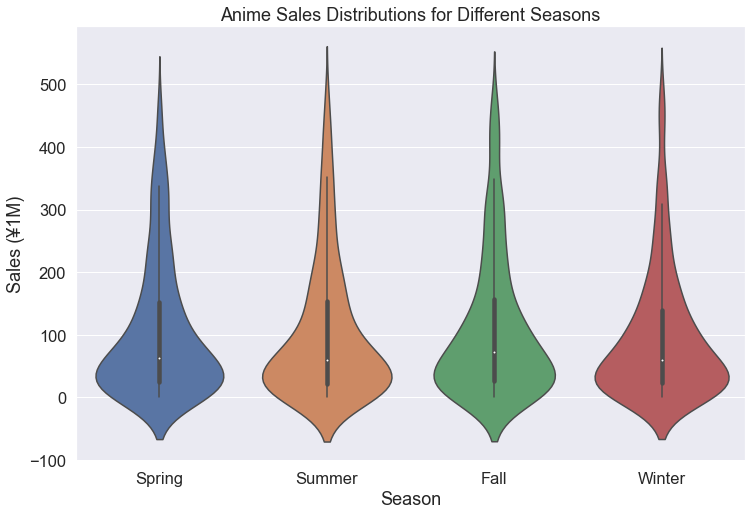

In [176]:
print(data_df.groupby("season_qtr")["sales"].agg(['mean', 'std']))
g = sns.violinplot(data=data_df, x="season_qtr", y="sales", order=["Spring", "Summer", "Fall", "Winter"]);
g.set_title("Anime Sales Distributions for Different Seasons")
g.set_xlabel("Season")
g.set_ylabel("Sales (¥1M)");

                 mean         std
day                              
Friday     100.245062  113.402867
Monday      94.416092  109.344609
Saturday    80.892424   89.063342
Sunday     107.058503  114.533338
Thursday    92.448077  103.508762
Tuesday    119.815789  127.659158
Wednesday   93.005634  108.027691


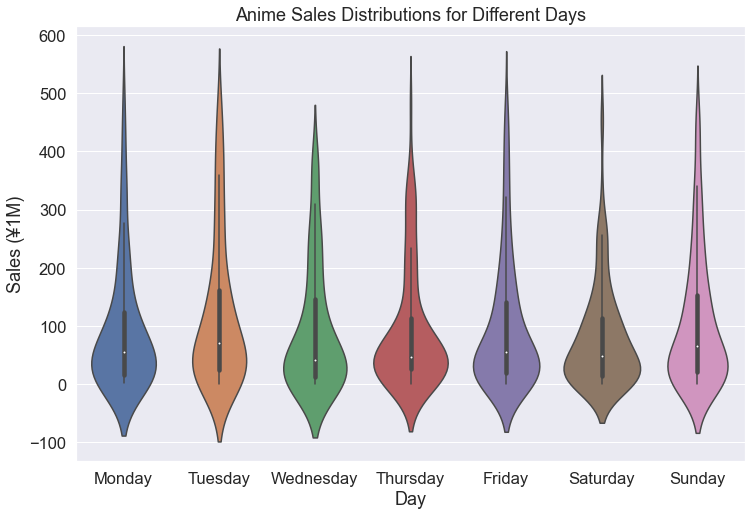

In [177]:
print(data_df.groupby("day")["sales"].agg(['mean', 'std']))
g = sns.violinplot(data=data_df, x="day", y="sales", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
g.set_title("Anime Sales Distributions for Different Days")
g.set_xlabel("Day")
g.set_ylabel("Sales (¥1M)");

So it looks like season/day aren't particularly predictive. The means and standard deviations are similar, and eyeballing suggests fairly similar distributions among categories. It may be that the variance within each category of each feature is such the k-folds cross-validation split score may have been dragged down by variance within the season-sales/day-sales relationship over the train/validation splits.


Let's do some statistical tests to see whether the distributions of sales differ among the season and day categories.

We use the [Kruskal-Wallis H-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) from SciPy, which tests whether the medians of some response variable differ for different populations, where the distributions need not be normal (as ours clearly aren't). (We're unable to use other tests that test for the same mean, such as one-way ANOVA, due to the non-normality.)

Our null hypothesis is that the medians of sales distributions for anime aired in different seasons or on different days are the same.

In [178]:
season_sales = data_df.groupby(["season_qtr"])["sales"].aggregate(lambda x: list(x))
stat, p = kruskal(*season_sales)
print("p-value for season is:", p)

p-value for season is: 0.5616271682701728


In [179]:
season_sales = data_df.groupby(["day"])["sales"].aggregate(lambda x: list(x))
stat, p = kruskal(*season_sales)
print("p-value for day is:", p)

p-value for day is: 0.4196128931259639


For both tests, $p >0.05$ and we fail to reject the null hypothesis, so it seems these categorical features are not predictive of sales.

### Rating and Source are predictive

              mean         std
rating                        
G       136.580000  133.986321
PG       97.375000   98.661102
PG-13   102.095820  109.740516
R        96.100885  103.667032
R+      137.274286  114.684239


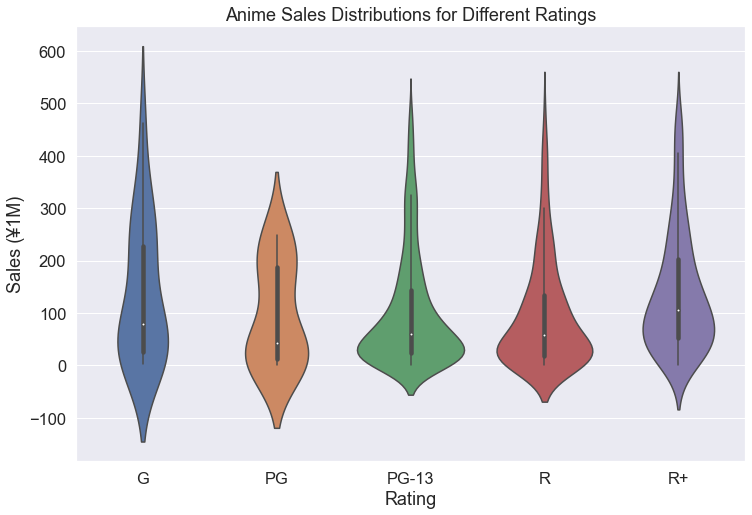

In [180]:
print(data_df.groupby("rating")["sales"].agg(['mean', 'std']))
g = sns.violinplot(data=data_df, x="rating", y="sales", order=["G", "PG", "PG-13", "R", "R+"]);
g.set_title("Anime Sales Distributions for Different Ratings")
g.set_xlabel("Rating")
g.set_ylabel("Sales (¥1M)");

The means don't look too different here, but these distributions certainly look distinct. Perhaps we can get some information out of the different shapes of the distributions.

                    mean         std
source                              
game          103.397222  109.750715
manga          97.793761  106.905637
novel         125.431102  117.708745
original      100.711450  108.318127
visual novel  107.338095  102.787934


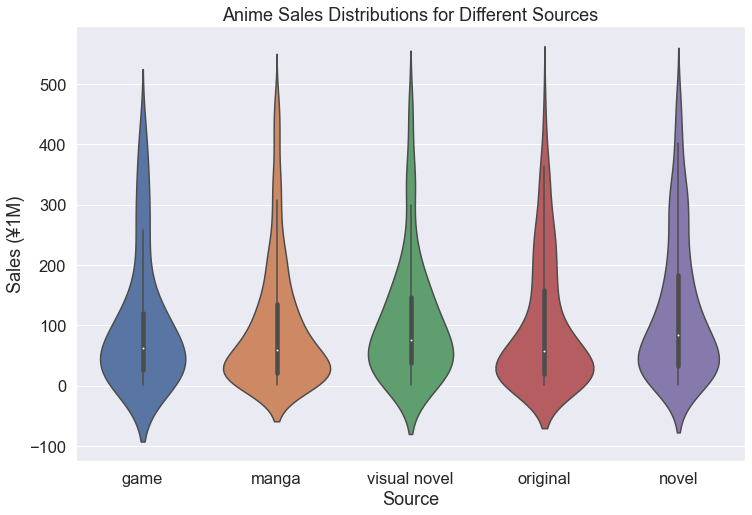

In [181]:
print(data_df.groupby("source")["sales"].agg(['mean', 'std']))
g = sns.violinplot(data=data_df, x="source", y="sales");
g.set_title("Anime Sales Distributions for Different Sources")
g.set_xlabel("Source")
g.set_ylabel("Sales (¥1M)");

The distributions look somewhat different, but eyeballing doesn't seem as helpful here. Let's calculate the statistics for both rating and source.

In [182]:
season_sales = data_df.groupby(["rating"])["sales"].aggregate(lambda x: list(x))
stat, p = kruskal(*season_sales)
print("p-value for rating is:", p)

p-value for rating is: 6.020272317231039e-05


In [183]:
season_sales = data_df.groupby(["source"])["sales"].aggregate(lambda x: list(x))
stat, p = kruskal(*season_sales)
print("p-value for source is:", p)

p-value for source is: 0.002139980719380545


As expected, the p-values are both significantly less than $0.05$, suggesting that the variables may be predictive.

### Polynomial Regression

Now let's try out polynomial regression. Additionally, we'll use only lasso from now on as it has been consistently better and should perform well as the feature count rises.

In [184]:
features = ["score", "year", "members", "rating", "source"]

lm_l, cv_score_l, scaler_l = lasso_regress(features, polynomial=True)
print(cv_score_l)

Poly input features: 13
Poly output features: 105
0.17203960790271888


At least for this set of features, polynomial regression with degree 2 does slightly better than non-polynomial.

## Genre Feature Engineering


Now let's add genre. Additionally, we'll use only lasso from now on as it has been consistently better.

In [185]:
features = ["score", "year", "members", "rating", "source"]
features.extend(genre_list)

lm_l, cv_score_l, scaler_l = lasso_regress(features)
print(cv_score_l)

0.18459600878749594


It looks like genre helps us a fair bit out of the box, even though there may be a lot of collinearity, and we have a lot of rarely-seen genres at the end that may be causing excessive variance. We'd like to pare down the list somewhat and/or reduce collinearity.

In [186]:
genres_by_frequency = data_df[genre_list].agg(sum).sort_values(ascending=False)
genres_by_frequency

Comedy           641.0
Action           448.0
Romance          405.0
School           371.0
Drama            347.0
Fantasy          306.0
Supernatural     259.0
Sci-Fi           252.0
Slice of Life    252.0
Shounen          234.0
Ecchi            182.0
Adventure        175.0
Seinen           171.0
Magic            143.0
Harem            141.0
Mystery          123.0
Mecha             97.0
Historical        84.0
Super Power       80.0
Shoujo            74.0
Demons            69.0
Sports            64.0
Military          63.0
Psychological     61.0
Music             58.0
Parody            42.0
Game              39.0
Horror            37.0
Martial Arts      34.0
Space             33.0
Josei             30.0
Samurai           29.0
Shoujo Ai         27.0
Vampire           27.0
Thriller          18.0
Police            18.0
Shounen Ai        16.0
dtype: float64

### Genres: Top X Approach

As a simple approach, let's consider keeping the top x genres.

In [187]:
def top_genres(num):
    """
    A helper function to return the num most frequent genres
    """
    return genres_by_frequency.head(num).index.tolist()

In [188]:
features = ["score", "year", "members", "rating", "source"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    features_mod = np.concatenate([features, top_genres(num)])
    _, cv_score_l, _ = lasso_regress(features_mod)
    cv_scores.append(cv_score_l)

Maximum score occurs at: 25
Maximum score is: 0.18809855052635782


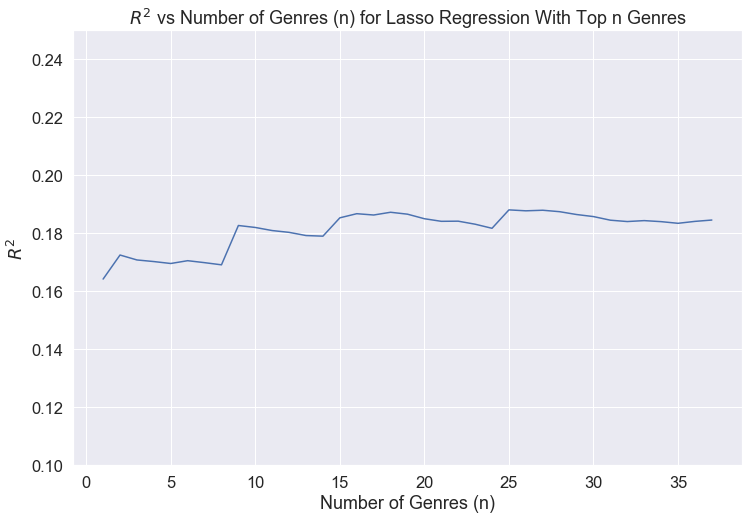

In [189]:
print("Maximum score occurs at:", np.argmax(cv_scores)+1)
print("Maximum score is:", np.max(cv_scores))
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0.1, 0.25);
g.set_title("$R^2$ vs Number of Genres (n) for Lasso Regression With Top n Genres")
g.set_xlabel("Number of Genres (n)")
g.set_ylabel("$R^2$");

We see a peak at 25 genres, and we've improved on our previous strategy of including all the genres.

There might be a better subset of genres, though. We could try forward subset selection.

### Genres: Forward Subset Selection

In [190]:
features = ["score", "year", "members", "rating", "source"]

_, original_cv_score, _ = lasso_regress(features)

selection_cv_scores = [original_cv_score]

selected_genres = []
current_genre = None
genres_left = list(genre_list)

while True:
    best_score = selection_cv_scores[-1]
    best_genre = None
    for genre in genres_left:
        current_genre = genre
        new_features = np.concatenate([features, selected_genres,\
                                      [current_genre]])
        _, cv_score_l, _ = lasso_regress(new_features)
        
        if cv_score_l > best_score:
            best_score = cv_score_l
            best_genre = genre
            
    if best_genre:
        selection_cv_scores.append(best_score)
        selected_genres.append(best_genre)
        genres_left.remove(best_genre)
    else:
        break
        
print("Score progression:", list(zip(list(["None"] + selected_genres), selection_cv_scores)))
print("Best score:", selection_cv_scores[-1])

Score progression: [('None', 0.16363195805504083), ('Slice of Life', 0.1727702502941052), ('Action', 0.18442085690628085), ('Harem', 0.19255298414666455), ('Music', 0.19677323028034366), ('Police', 0.1980347997140468), ('Sci-Fi', 0.19876155705202414), ('Comedy', 0.19983980807433), ('Shounen Ai', 0.20052051687589512), ('Historical', 0.20128960613761027), ('Shoujo Ai', 0.20213929954863252), ('Magic', 0.20233677791955018)]
Best score: 0.20233677791955018


We added fewer genres than before (11) but we've seen an improvement in $R^2$: subset selection worked better than simply naively taking the top X genres.

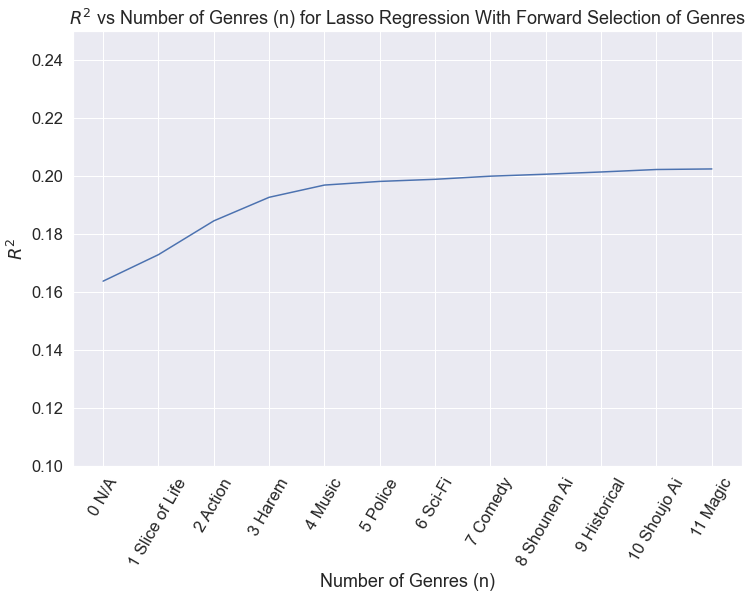

In [191]:
g = sns.lineplot(x=range(len(selection_cv_scores)), y=selection_cv_scores)
selected_genres_add_na = np.concatenate([["N/A"], selected_genres])
labels = [str(i) + " " + selected_genres_add_na[i] for i in range(len(selected_genres_add_na))]
g.set_xticks(range(len(selected_genres_add_na)))
g.set_xticklabels(labels, rotation=60)
g.set_ylim(0.1, 0.25)

g.set_title("$R^2$ vs Number of Genres (n) for Lasso Regression With Forward Selection of Genres")
g.set_xlabel("Number of Genres (n)")
g.set_ylabel("$R^2$");

### Best solution thus far

Before we do any more complex feature engineering, let's note our preliminary set of best features.

In [192]:
best_features = np.concatenate([["score", "year", "members", "rating", "source"], selected_genres])
best_features

array(['score', 'year', 'members', 'rating', 'source', 'Slice of Life',
       'Action', 'Harem', 'Music', 'Police', 'Sci-Fi', 'Comedy',
       'Shounen Ai', 'Historical', 'Shoujo Ai', 'Magic'], dtype='<U13')

### Genres: PCA

Let's try PCA on genres.

In [193]:
genre_columns = X_trainval[genre_list]

# let's precalculate all the components
pca = PCA(len(genre_list))
decomp = pca.fit_transform(genre_columns)
pca_cols = ["pc_" + str(i) for i in range(1, len(genre_list)+1)]
X_trainval = pd.concat([X_trainval, pd.DataFrame(decomp, columns=pca_cols, index = X_trainval.index)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(pca.transform(X_test[genre_list]), columns=pca_cols, index=X_test.index)], axis=1)

In [194]:
features = ["score", "year", "members", "rating", "source"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    features_mod = np.concatenate([features, pca_cols[:num]])
    _, cv_score_l, _ = lasso_regress(features_mod)
    cv_scores.append(cv_score_l)

print("Maximum score occurs at:", np.argmax(cv_scores))
print("Maximum score is:", np.max(cv_scores))

Maximum score occurs at: 20
Maximum score is: 0.18875360864690782


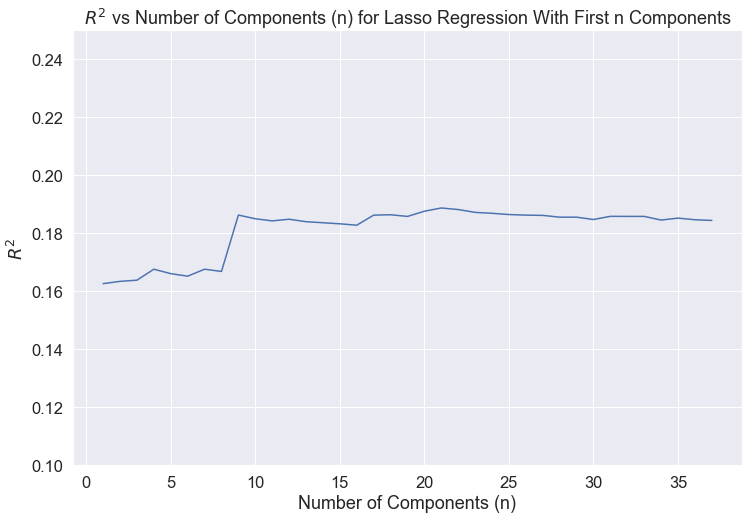

In [195]:
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0.1, 0.25);

g.set_title("$R^2$ vs Number of Components (n) for Lasso Regression With First n Components")
g.set_xlabel("Number of Components (n)")
g.set_ylabel("$R^2$");

We did slightly better than the top n method. Let's try our forward selection method.

### Genres: PCA & Forward Selection

In [196]:
features = ["score", "year", "members", "rating", "source"]

_, original_cv_score, _ = lasso_regress(features)

selection_cv_scores = [original_cv_score]

selected_comps = []
current_comp = None
comps_left = list(pca_cols)

while True:
    best_score = selection_cv_scores[-1]
    best_comp = None
    for comp in comps_left:
        current_comp = comp
        new_features = np.concatenate([features, selected_comps, [current_comp]])
        _, cv_score_l, _ = lasso_regress(new_features)
        
        if cv_score_l > best_score:
            best_score = cv_score_l
            best_comp = comp
            
    if best_comp:
        selection_cv_scores.append(best_score)
        selected_comps.append(best_comp)
        comps_left.remove(best_comp)
    else:
        break
        
print("Score progression:", list(zip(list(["None"] + selected_comps), selection_cv_scores)))
print("Best score:", selection_cv_scores[-1])

Score progression: [('None', 0.16363195805504083), ('pc_9', 0.18463174184493014), ('pc_17', 0.18875313345818234), ('pc_4', 0.19178185498938172), ('pc_20', 0.19463573962312963), ('pc_7', 0.19649572897655831), ('pc_31', 0.19778876933399003), ('pc_21', 0.19873370758529574), ('pc_35', 0.19961116094749376), ('pc_2', 0.20057561157523607), ('pc_12', 0.20096005781419768), ('pc_18', 0.20122971914689947), ('pc_26', 0.2014454166400096), ('pc_14', 0.20150654011853242)]
Best score: 0.20150654011853242


We did slightly worse than the genre selection approach. This might be because the variance in the data aren't necessarily best explained best by the principal components, or that the principal components are comparable to the genres. It would be interesting to evaluate whether an exhaustive subset search or a more sophisticated selection algorithm, e.g. recursive feature elimination, would improve even more, either on genres or genre principal components.

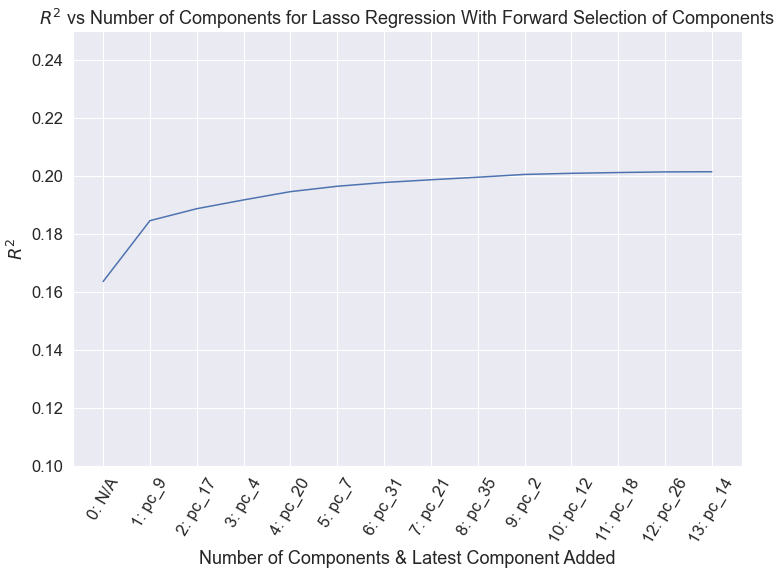

In [197]:
g = sns.lineplot(x=range(len(selection_cv_scores)), y=selection_cv_scores)
selected_comps_add_na = np.concatenate([["N/A"], selected_comps])
labels = [str(i) + ": " + selected_comps_add_na[i] for i in range(len(selected_comps_add_na))]
g.set_xticks(range(len(selected_comps_add_na)))
g.set_xticklabels(labels, rotation=60)
g.set_ylim(0.1, 0.25)
g.set_title("$R^2$ vs Number of Components for Lasso Regression With Forward Selection of Components")
g.set_xlabel("Number of Components & Latest Component Added")
g.set_ylabel("$R^2$");

### Genres: K-means clustering

Let's try a different approach to genre: K-means.

In [198]:
def cluster_genres(clusters, by_pca=False, comps_to_use=None):
    """
    Cluster the data by K-means, then set the "genre_cluster" feature column 
    in our data to the relevant cluster.
    
    :param int clusters: the number of clusters
    :param bool by_pca: whether to cluster by PCA, default False
    :param list of str comps_to_use: if clustering by PCA, a list of the 
        column names of the components to cluster by, default None
    """
    cluster_by = genre_list if not by_pca else comps_to_use
    cluster_cols = X_trainval[cluster_by]
    
    kmeans = KMeans(n_clusters = clusters, random_state=50, n_init = 50, max_iter = 500)
    kmeans.fit(cluster_cols)
    
    X_trainval["genre_cluster"] = kmeans.predict(cluster_cols)
    X_test["genre_cluster"] = kmeans.predict(X_test[cluster_by])

In [199]:
features = ["score", "year", "members", "rating", "source", "genre_cluster"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    cluster_genres(num)
    #features_mod = np.concatenate([features, pca_cols[:num]])
    _, cv_score_l, _ = lasso_regress(features)
    cv_scores.append(cv_score_l)

print("Maximum score occurs at:", np.argmax(cv_scores))
print("Maximum score is:", np.max(cv_scores))

Maximum score occurs at: 12
Maximum score is: 0.1671611736972307


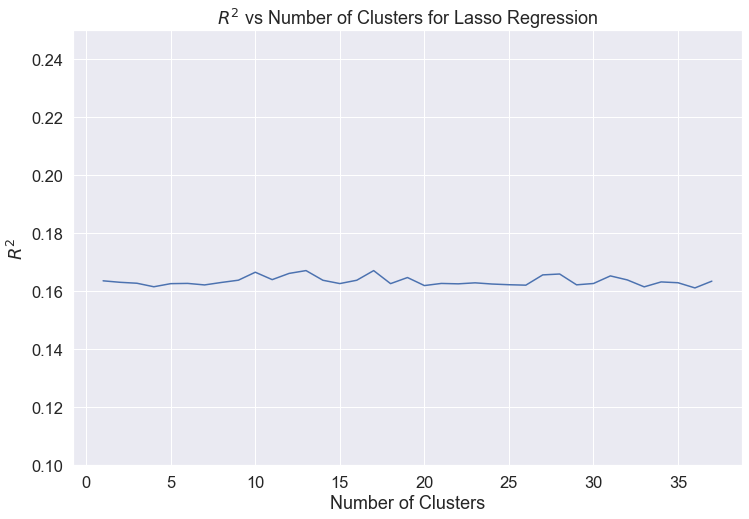

In [200]:
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0.1, 0.25);
g.set_title("$R^2$ vs Number of Clusters for Lasso Regression")
g.set_xlabel("Number of Clusters")
g.set_ylabel("$R^2$");

We did rather poorly here. Let's see if clustering based on principal components works any better. We need to select the number of principal components to cluster on this time; let's do it in order of component selection from the previous approach.

### Genres: Clustering by principal components

In [201]:
features = ["score", "year", "members", "rating", "source", "genre_cluster"]

cv_scores_cluster_pca = {}

for comps in range(1, len(selected_comps)+1):
    cv_scores_one_comp = []
    for clusters in range(1, len(genre_list)+1):
        cluster_genres(clusters, by_pca=True, comps_to_use=selected_comps[:comps])
    
        _, cv_score_l, _ = lasso_regress(features)
        cv_scores_one_comp.append(cv_score_l)
    print(max(cv_scores_one_comp))
    cv_scores_cluster_pca[comps] = cv_scores_one_comp

0.17386799710673106
0.18119318536562545
0.171547204827608
0.1687557380424819
0.1716369687630932
0.1705564201067964
0.17304703519246967
0.17355088595735324
0.1671988982115259
0.1694208914686406
0.17263919869377775
0.17267755242332894
0.1697902218287679


Unfortunately this approach doesn't seem to have borne fruit. It would be worth exploring in the future whether this approach has any benefits given slight modifications.

## Revisiting our best model

Our best model in the end has features score, year, number, and rating, as well as 11 selected genres.

In [202]:
final_features = np.concatenate([["score", "year", "members", "rating", "source"], selected_genres])

lm_final, cv_score, scaler_final = lasso_regress(final_features)

For our final R2 and RMSE test scores we get:

In [203]:
y_predict_final = lm_final.predict(scaler_final.transform(pd.get_dummies(X_test[final_features])))
print("R2 score:", r2_score(y_test, y_predict_final))
print("RMSE:", mean_squared_error(y_test, y_predict_final)**0.5)

R2 score: 0.16070960542121904
RMSE: 99.36450415818858


Suggestive of moderate overfitting, but nonetheless an improvement on our base model. Given our $R^2$ value it seems that our variance is significantly higher than our predictors can explain.

The coefficients and intercept are:

In [210]:
list(zip(final_features, lm_final.coef_))

[('score', 32.70058912855494),
 ('year', -21.59424513125039),
 ('members', 14.36020638439262),
 ('rating', 16.809726405567858),
 ('source', 15.219278455411335),
 ('Slice of Life', 11.167587880889613),
 ('Action', 8.96880908674466),
 ('Harem', -4.469071974692336),
 ('Music', 7.786921940482722),
 ('Police', 5.989907697797788),
 ('Sci-Fi', 5.748141739014909),
 ('Comedy', 5.884065843178484),
 ('Shounen Ai', 4.340547118619989),
 ('Historical', 4.137084776857718),
 ('Shoujo Ai', 1.9750215925403078),
 ('Magic', -2.511766814463376)]

In [211]:
lm_final.intercept_

105.74650717703335

So score, year, members, rating, and source are the top non-genre predictors. After that, we see that a variety of genres are predictive in that they tend to sell better or worse than the mean.

Plot the residuals:

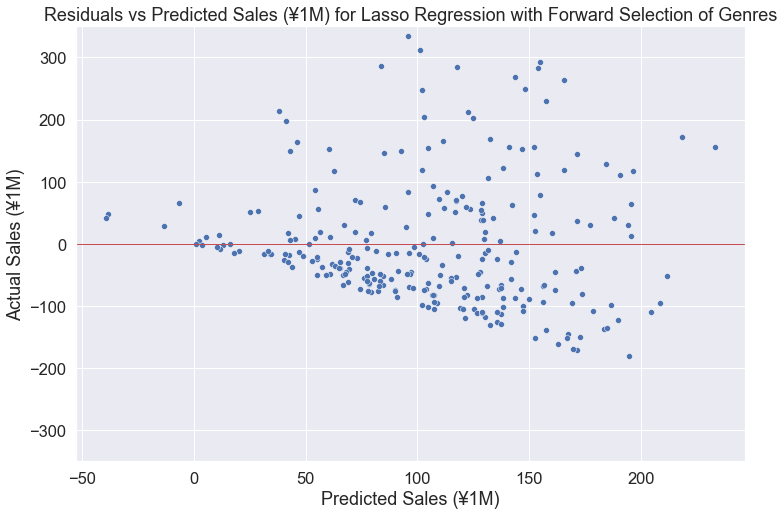

In [212]:
g = sns.scatterplot(x=y_predict_final, y=y_test-y_predict_final)
plt.axhline(linewidth=1, color='r');
g.set_title("Residuals vs Predicted Sales (¥1M) for Lasso Regression with Forward Selection of Genres")
g.set_xlabel("Predicted Sales (¥1M)")
g.set_ylabel("Actual Sales (¥1M)");
g.set_ylim((-350, 350));

We do continue to see a pattern of more widely-spread residuals with larger predictions. Further work might be done to address this issue.